In [1]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
import rich.console


_orig_console = rich.console.Console


class Console(_orig_console):
    def __init__(self, *args, **kwargs):
        kwargs["force_terminal"] = True
        super().__init__(*args, **kwargs)


rich.console.Console = Console
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
pandarallel.initialize(progress_bar=False, nb_workers=16)
base_dir="/root/vllm/examples/analysis/data/eos_result/"

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# EoS Prob Analysis

In [2]:
model_names = ["llama", "mistral"]
dataset_names = ["alpaca", "sharegpt"]
dataset_name_map = {"alpaca": "Alpaca", "sharegpt": "ShareGPT"}
model_name_map = {"llama": "Llama", "mistral": "Mistral"}

eos_prob_rank_result_df = pd.DataFrame()
for model_name in model_names:
    for dataset_name in dataset_names:
        tmp_df = pd.read_csv(
            f"{base_dir}/{model_name}_{dataset_name}_eos_prob_result.csv"
        )
        tmp_df["model_dataset"] = (
            model_name_map[model_name] + " " + dataset_name_map[dataset_name]
        )
        eos_prob_rank_result_df = pd.concat([eos_prob_rank_result_df, tmp_df])
eos_prob_rank_result_df = eos_prob_rank_result_df[
    eos_prob_rank_result_df["eos_prob"] != 0
]

In [3]:
def get_init_rank(group):
    # Find the row with the minimum token_num
    min_token_num = group["token_num"][:20].min()
    min_token_row = group[group["token_num"] == min_token_num]

    # Find the maximum token_num
    max_token_num = group["token_num"].max()

    # Create a DataFrame with the results
    result_df = pd.DataFrame(
        {
            "min_eos_token_rank": [min_token_row["eos_token_rank"].values[0]],
            "max_token_num": [max_token_num],
        }
    )

    return result_df


# Assuming eos_prob_rank_result_df is your DataFrame
result = (
    eos_prob_rank_result_df.groupby(["request_id", "model_dataset"])
    .parallel_apply(get_init_rank)
    .reset_index()
)

# Flatten the resulting DataFrame
result = result.drop(columns=["level_2"]).rename(columns={0: "result"})

In [4]:
def get_eos_max_token_nums(row):
    eos_prob = max(row["eos_prob"][: min(len(row), 15)])
    max_token_nums = max(row["token_num"])
    return eos_prob, max_token_nums

eos_prob_result = (
    eos_prob_rank_result_df[
        (
            eos_prob_rank_result_df["prompt_len"]
            + eos_prob_rank_result_df["token_num"]
            < 2048
        )
        & (eos_prob_rank_result_df["token_num"] > 15)
    ]
    .groupby(["request_id", "model_dataset"])
    .parallel_apply(
        lambda row: pd.Series(
            get_eos_max_token_nums(row), index=["eos_prob", "max_token_nums"]
        )
    )
    .reset_index()
)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


def get_predicted_result(row):
    def linear_regression(X, y):
        model = LinearRegression()
        model.fit(X, y)
        result = model.predict(X)
        print("MSE: ", mean_squared_error(y, result))
        print("MAE", mean_absolute_error(y, result))
        print("R-squared: ", model.score(X, y))

    X = row[["eos_prob"]]
    y = row["max_token_nums"]
    linear_regression(X, y)


eos_prob_result.groupby(["model_dataset"])[
    ["eos_prob", "max_token_nums"]
].apply(lambda row: get_predicted_result(row))

MSE:  151724.13878864006
MAE 249.3340722429203
R-squared:  0.051469529245834034
MSE:  144177.47140153876
MAE 234.3239662181705
R-squared:  0.05674287321855087
MSE:  9773.611006059873
MAE 60.62133556081058
R-squared:  0.12021293768888575
MSE:  9017.14982405732
MAE 52.57659253309423
R-squared:  0.09831658628374618


""


### correlations between left token number and max probability of EOS

In [ ]:
from scipy.stats import spearmanr, pearsonr

def calc_eos_prob_output_len_corr(row):
    init_length = 15
    if (
        len(row["eos_token_rank"]) < init_length
        or max(row["token_num"]) < init_length
    ):
        return -1

    token_nums = max(row["token_num"]) - row["token_num"]
    token_nums = np.array(token_nums.tolist())
    eos_token_probs = row["eos_prob"].tolist()
    max_eos_token_prob = np.array(
        [
            max(eos_token_probs[max(-init_length, 0) : i])
            for i in range(1, len(eos_token_probs) + 1)
        ]
    )
    if np.std(max_eos_token_prob) == 0 or np.std(token_nums) == 0:
        return -1
    return pearsonr(token_nums, max_eos_token_prob).statistic


eos_prob_seq_len_corrs = (
    eos_prob_rank_result_df.groupby(["request_id", "model_dataset"])
    .parallel_apply(lambda row: calc_eos_prob_output_len_corr(row))
    .reset_index()
)
eos_prob_seq_len_corrs["corr"] = eos_prob_seq_len_corrs[0]

/tmp/ipykernel_3927791/68125950.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(token_nums, max_eos_token_prob).statistic
/tmp/ipykernel_3927791/68125950.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(token_nums, max_eos_token_prob).statistic
/tmp/ipykernel_3927791/68125950.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(token_nums, max_eos_token_prob).statistic
/tmp/ipykernel_3927791/68125950.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(token_nums, max_eos_token_prob).statistic
/tmp/ipykernel_3927791/68125950.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(token_nums, max_eos_token_prob).statistic
/tmp/ipykernel_3927791/68125950.py:

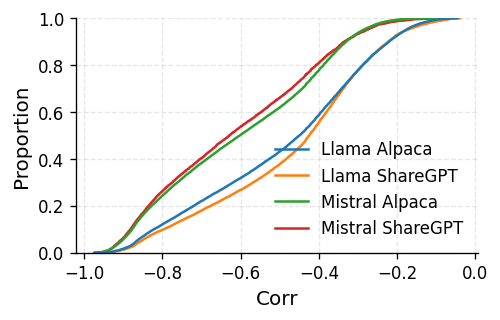

In [7]:
plt.figure(figsize=(4, 2.5), dpi=120)
ax = sns.ecdfplot(
    eos_prob_seq_len_corrs[eos_prob_seq_len_corrs["corr"] > -1],
    x="corr",
    hue="model_dataset",
)
ax_legend = ax.get_legend()
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel("Corr", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
ax_legend.set(ncols=4, frame_on=False, title="")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout(h_pad=0, pad=0.1)
plt.savefig("/root/vllm/examples/analysis/data/fig/seq_len_eos_rank_corr.pdf")
plt.show()

In [ ]:
def calc_expected_left_length(row, init_length):
    if len(row) > 2048 or max(row["token_num"]) < init_length:
        return -1, -1

    token_nums = max(row["token_num"])
    eos_token_ranks = row["eos_prob"].tolist()
    # differences = (
    #     np.max(eos_token_ranks[:init_length])
    #     - np.min(eos_token_ranks[:init_length])
    # ) / init_length
    # average_difference = np.mean(differences)
    # differences = np.diff(max_eos_token_rank[:5])
    # differences = np.mean(differences)
    differences = np.std(eos_token_ranks[:init_length])
    return differences, token_nums

def get_estimate_accuracy(expected_accuracy, model):
    llama_alpaca_expected_accuracy = expected_accuracy[
        expected_accuracy["model_dataset"] == model
    ]
    selected_llama_alpaca_expected_accuracy = (
        llama_alpaca_expected_accuracy.sample(6000)
    )
    llama_alpaca_expected_accuracy_merge = (
        selected_llama_alpaca_expected_accuracy.assign(key=1)
        .merge(selected_llama_alpaca_expected_accuracy.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    llama_alpaca_expected_accuracy_merge["req_ids"] = (
        llama_alpaca_expected_accuracy_merge["request_id_x"]
        + llama_alpaca_expected_accuracy_merge["request_id_y"]
    )
    llama_alpaca_expected_accuracy_merge = (
        llama_alpaca_expected_accuracy_merge.drop_duplicates(subset="req_ids")
    )
    filter1 = (
        llama_alpaca_expected_accuracy_merge["eos_prob_diff_x"]
        >= llama_alpaca_expected_accuracy_merge["eos_prob_diff_y"]
    )
    filter2 = (
        llama_alpaca_expected_accuracy_merge["max_token_nums_x"]
        <= llama_alpaca_expected_accuracy_merge["max_token_nums_y"]
    )
    filter3 = (
        llama_alpaca_expected_accuracy_merge["eos_prob_diff_x"]
        <= llama_alpaca_expected_accuracy_merge["eos_prob_diff_y"]
    )
    filter4 = (
        llama_alpaca_expected_accuracy_merge["max_token_nums_x"]
        >= llama_alpaca_expected_accuracy_merge["max_token_nums_y"]
    )
    accuracy = len(
        llama_alpaca_expected_accuracy_merge[
            (filter1 & filter2) | (filter3 & filter4)
        ]
    ) / len(llama_alpaca_expected_accuracy_merge)
    return accuracy


def get_expected_accuracy_df(eos_prob_rank_result_df, init_length):
    expected_accuracy = (
        eos_prob_rank_result_df.groupby(["request_id", "model_dataset"])
        .parallel_apply(
            lambda row: pd.Series(
                calc_expected_left_length(row, init_length),
                index=["eos_prob_diff", "max_token_nums"],
            )
        )
        .reset_index()
    )
    expected_accuracy = expected_accuracy[
        expected_accuracy["eos_prob_diff"] != -1
    ]
    return expected_accuracy

def process_model_init_length(args):
    init_length, model, eos_prob_rank_result_df = args
    expected_accuracy = get_expected_accuracy_df(eos_prob_rank_result_df, init_length)
    accuracy = get_estimate_accuracy(expected_accuracy, model)
    return model, init_length, accuracy

models = [
    "Llama Alpaca",
    "Llama ShareGPT",
    "Mistral Alpaca",
    "Mistral ShareGPT",
]
init_lengths = [10, 12, 15, 20, 22, 25]
estimated_accuracy = {"models": [], "init_length": [], "accuracy": []}


for init_length in init_lengths:
    expected_accuracy = get_expected_accuracy_df(eos_prob_rank_result_df, init_length)
    for model in models:
        accuracy = get_estimate_accuracy(expected_accuracy, model)
        estimated_accuracy["models"].append(model)
        estimated_accuracy["init_length"].append(init_length)
        estimated_accuracy["accuracy"].append(accuracy)
estimated_accuracy = pd.DataFrame(estimated_accuracy)
estimated_accuracy.to_csv(f"{base_dir}/estimated_accuracy_cov.csv")

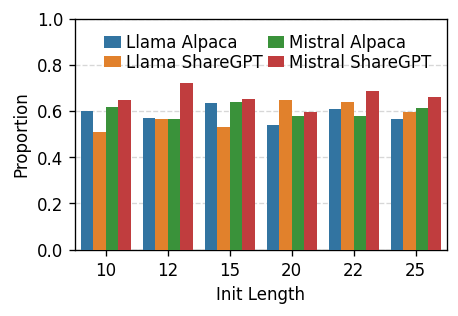

In [17]:
plt.figure(figsize=(4, 2.5), dpi=120)
sns.barplot(
    data=estimated_accuracy,
    x="init_length",
    y="accuracy",
    hue="models",
    zorder=10,
)
plt.ylim(0, 1)
plt.legend(
    loc="best",
    ncol=2,
    frameon=False,
    labelspacing=0.1,
    handlelength=1,
    handletextpad=0.3,
    columnspacing=0.3,
)
plt.xlabel("Init Length")
plt.ylabel("Proportion")
plt.grid(True, axis="y", alpha=0.5, ls="--", zorder=0)
plt.savefig("estimated_accuracy.pdf")
plt.show()

## test warm up window size

In [ ]:
def max_eos_prob_left_seq_len(row, i):
    if len(row) <= i:
        return pd.Series([-1, -1], index=["max_eos_prob", "left_seq_len"])
    # max_eos_prob = np.std(row["eos_prob"][:i]) / np.mean(
    #     row["eos_prob"][:i]
    # )
    max_eos_prob = np.max(row["eos_token_rank"][:i])
    left_seq_len = max(row["token_num"]) - min(row["token_num"][i:])
    tmp_df = pd.Series(
        [max_eos_prob, left_seq_len], index=["max_eos_prob", "left_seq_len"]
    )


corrs = []
for i in range(1, 50):
    eos_prob_left_seq_len = (
        eos_prob_rank_result_df.groupby(["request_id"])
        .parallel_apply(lambda row: max_eos_prob_left_seq_len(row, i))
        .reset_index()
        .drop(columns=["request_id"])
    )
    corrs.append(
        eos_prob_left_seq_len[eos_prob_left_seq_len["max_eos_prob"] >= 0]
        .corr(method="spearman")
        .loc["max_eos_prob", "left_seq_len"]
    )
plt.figure(figsize=(4, 2.5), dpi=150)
print(corrs)
sns.lineplot(corrs, hue="model_dataset")
plt.xlabel("# of Iters")
plt.ylabel("Corr. Seq Len vs. Prob")
plt.grid(alpha=0.3, linestyle="--")
plt.show()
print(corrs)

In [ ]:
def eos_prob_predict_len(row, i):
    if len(row) <= i:
        return pd.Series([-1, -1], index=["pred_len", "left_seq_len"])
    # max_eos_prob = np.std(row["eos_token_rank"][:i]) / np.mean(
    #     row["eos_prob"][:i]
    # )

    max_eos_prob = 1 - np.max(row["eos_token_rank"][:i]) / 32000
    _n = int(-np.log(np.max(row["eos_token_rank"][:i]))) + 23
    predict_len = (
        max_eos_prob
        * (1 + _n * max_eos_prob ** (_n + 1) - (_n + 1) * max_eos_prob**_n)
        / ((1 - max_eos_prob) ** 2)
    )

    left_seq_len = max(row["token_num"]) - min(row["token_num"][i:])
    return pd.Series(
        [predict_len, left_seq_len], index=["pred_len", "left_seq_len"]
    )


eos_pred_len_df = (
    eos_prob_rank_result_df.groupby(["request_id"])
    .apply(
        lambda row: eos_prob_predict_len(row, 3),
        include_groups=False,
    )
    .reset_index()
    .drop(columns=["request_id"])
)
eos_pred_len_df

In [ ]:
_tmp_eos_prob_rank_result_df = eos_prob_rank_result_df[
    eos_prob_rank_result_df["request_id"] == 0
]
_tmp_eos_prob_rank_result_df["left_seq_len"] = (
    max(_tmp_eos_prob_rank_result_df["token_num"])
    - _tmp_eos_prob_rank_result_df["token_num"]
)
_tmp_eos_prob_rank_result_df

In [ ]:
seq_output_len = (
    eos_prob_rank_result_df.groupby(["prompt_len"])
    .agg({"token_num": "mean"})
    .reset_index()
)